# Importation of libraries

In [11]:
# Standard libraries
import pandas as pd
import numpy as np

# Non-standard Libaries
from FeatureEngineering.credit_sales_machine_learning import CreditSales

# B. Loading of datasets

## 1. Revenues

In [12]:
df_revenues = pd.read_excel(r"Database\revenues_pseudonymized.xlsx")

In [13]:
df_revenues

,entry_number,entry_date,due_date,school_year,student_id_pseudonimized,category_name,discount_refund_applied_to,amount_due,amount_paid,account_name,receivables
0,0,2025-10-13,2025-10-13,2014,9XBPS6GQ,Form 137,NaN,150.0,150.0,G-Cash,0.0
1,1,2016-01-01,2016-01-01,2016,QCNXOF71,Back Account,NaN,3524.0,0.0,Not Applicable,3524.0
2,2,2016-01-01,2016-01-01,2016,UFN5RBCA,Back Account,NaN,9831.0,0.0,Not Applicable,9831.0
3,3,2016-01-01,2016-01-01,2016,CATF26JR,Back Account,NaN,9240.0,0.0,Not Applicable,9240.0
4,4,2016-01-01,2016-01-01,2016,TE11Z2LJ,Back Account,NaN,5886.0,0.0,Not Applicable,5886.0
...,...,...,...,...,...,...,...,...,...,...,...
51186,53633,2026-02-11,2026-08-07,2026,0NVPQ4K1,G01-OF-1st,NaN,5467.0,5467.0,Cash,0.0
51187,53634,2026-02-11,2026-12-04,2026,0NVPQ4K1,G01-OF-2nd,NaN,5467.0,0.0,Not Applicable,5467.0
51188,53635,2026-02-11,2027-03-05,2026,0NVPQ4K1,G01-OF-3rd,NaN,5466.0,0.0,Not Applicable,5466.0
51189,53636,2026-02-11,2026-02-11,2026,B5DSEMMK,Assesment Fee,NaN,600.0,600.0,Cash,0.0


## 2. Enrollees

In [14]:
df_enrollees = pd.read_excel(r"Database\enrollees_pseudonymized.xlsx")

## 3. Credit Sales

In [15]:
cs = CreditSales(df_revenues, df_enrollees)
df_credit_sales = cs.show_data()

Single due date records: 10022
Multiple due date records: 257


In [16]:
df_credit_sales

,school_year,student_id_pseudonimized,category_name,gross_receivables,amount_discounted,adjustments,credit_sale_amount,due_date,date_fully_paid,last_payment_date,...,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,plan_type
0,2022,02PNVPI5,Kn2-C-1st,2800.0,0.0,0.0,2800.0,2022-09-09,2022-09-06,2022-08-04,...,<NA>,<NA>,0.0,<NA>,<NA>,36,29227.0,30227.0,0.0,Plan - C
1,2022,02PNVPI5,Kn2-C-2nd,2800.0,0.0,0.0,2800.0,2022-11-05,NaT,2022-09-06,...,<NA>,-3.0,-1.2,<NA>,<NA>,60,32027.0,30227.0,2800.0,Plan - C
2,2022,02PNVPI5,Kn2-OF-2nd,2267.0,0.0,0.0,2267.0,2022-12-05,NaT,2022-09-06,...,<NA>,-3.0,-0.9,<NA>,<NA>,90,34294.0,30227.0,5067.0,Plan - C
3,2022,02PNVPI5,Kn2 - Moving Up - Male,2600.0,0.0,0.0,2600.0,2022-12-16,NaT,2022-12-12,...,<NA>,-3.0,-0.6,<NA>,<NA>,4,38520.0,31027.0,8493.0,Plan - C
4,2022,02PNVPI5,Events - Foundation Day,490.0,0.0,0.0,490.0,2022-12-16,NaT,2022-12-12,...,-3,-3.0,-0.3,<NA>,<NA>,4,38520.0,31027.0,8493.0,Plan - C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274,2025,ZXPL0CI9,G06-C-2nd,5800.0,0.0,0.0,5800.0,2025-10-03,2025-10-27,2025-09-09,...,0,1.5,3.3,-15.0,-7.5,24,191320.0,185520.0,14734.0,Plan - C
10275,2025,ZXPL0CI9,G06-OF-2nd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,-3,7.5,12.3,-12.0,-13.5,39,203170.0,191570.0,14734.0,Plan - C
10276,2025,ZXPL0CI9,G06-C-3rd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,-3,16.75,22.9,-10.0,-11.0,39,203170.0,191570.0,14734.0,Plan - C
10277,2025,ZXPL0CI9,G06-C-4th,5800.0,0.0,0.0,5800.0,2026-02-06,2026-02-09,2026-01-08,...,12,26.0,29.8,0.0,-5.0,29,208970.0,203170.0,14734.0,Plan - C


In [17]:
df_credit_sales.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'])

# Drop plans D, E, and not enrolled
df_credit_sales = df_credit_sales[
    ~df_credit_sales['plan_type'].isin([4, 5]) & df_credit_sales['plan_type'].notna()
]

In [21]:
df_credit_sales

,school_year,student_id_pseudonimized,category_name,gross_receivables,amount_discounted,adjustments,credit_sale_amount,due_date,date_fully_paid,last_payment_date,...,dtp_4,dtp_avg,dtp_wavg,dtp_2_trend,dtp_3_trend,days_since_last_payment,amount_due_cumsum,amount_paid_cumsum,opening_balance,plan_type
15,2021,07EGT7GO,Kn2-C-3rd,2800.0,0.0,0.0,2800.0,2022-02-07,2022-01-29,2022-01-03,...,79,24.0,15.6,-29.0,-13.0,35,30960.0,30960.0,2425.0,Plan - C
16,2021,07EGT7GO,Kn2-C-4th,2800.0,0.0,0.0,2800.0,2022-04-04,2022-03-31,2022-01-29,...,-2,2.0,2.4,33.0,2.0,65,33760.0,33760.0,2425.0,Plan - C
21,2025,07HFC4W3,Kn2-C-4th,5400.0,-700.0,0.0,4700.0,2026-02-06,2026-01-29,2025-12-05,...,-7,-12.75,-12.7,-26.0,-6.0,63,61737.0,61037.0,0.0,Plan - C
22,2025,07HFC4W3,Kn2-OF-3rd,4933.0,0.0,0.0,4933.0,2026-03-06,NaT,2026-01-29,...,-14,-13.0,-10.8,6.0,-10.0,36,65970.0,61037.0,4933.0,Plan - C
29,2019,08GNGU9D,G04-OF-2nd,2900.0,0.0,0.0,2900.0,2019-12-06,2019-12-14,2019-10-29,...,284,165.5,129.9,160.0,59.5,38,60882.0,55117.0,5765.0,Plan - B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274,2025,ZXPL0CI9,G06-C-2nd,5800.0,0.0,0.0,5800.0,2025-10-03,2025-10-27,2025-09-09,...,0,1.5,3.3,-15.0,-7.5,24,191320.0,185520.0,14734.0,Plan - C
10275,2025,ZXPL0CI9,G06-OF-2nd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,-3,7.5,12.3,-12.0,-13.5,39,203170.0,191570.0,14734.0,Plan - C
10276,2025,ZXPL0CI9,G06-C-3rd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,-3,16.75,22.9,-10.0,-11.0,39,203170.0,191570.0,14734.0,Plan - C
10277,2025,ZXPL0CI9,G06-C-4th,5800.0,0.0,0.0,5800.0,2026-02-06,2026-02-09,2026-01-08,...,12,26.0,29.8,0.0,-5.0,29,208970.0,203170.0,14734.0,Plan - C


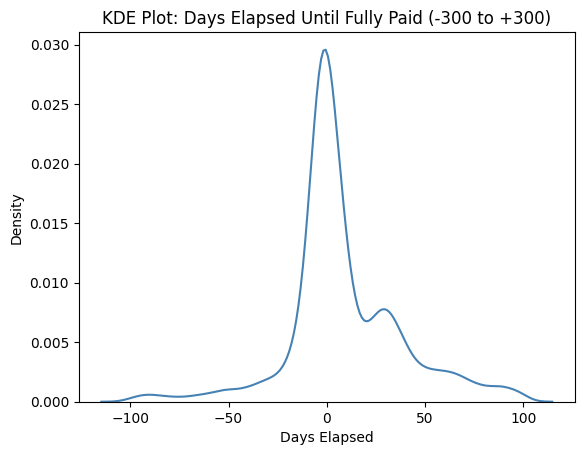

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Clean the column: drop NaNs and empty strings
cleaned_days = df_credit_sales['days_elapsed_until_fully_paid']
cleaned_days = cleaned_days.replace("", np.nan).dropna()

# Filter to range -300 to +300
filtered_days = cleaned_days[(cleaned_days >= -100) & (cleaned_days <= 100)]

# KDE plot
sns.kdeplot(
    x=filtered_days,
    fill=False,
    color="steelblue"
)

plt.title("KDE Plot: Days Elapsed Until Fully Paid (-300 to +300)")
plt.xlabel("Days Elapsed")
plt.ylabel("Density")
plt.show()

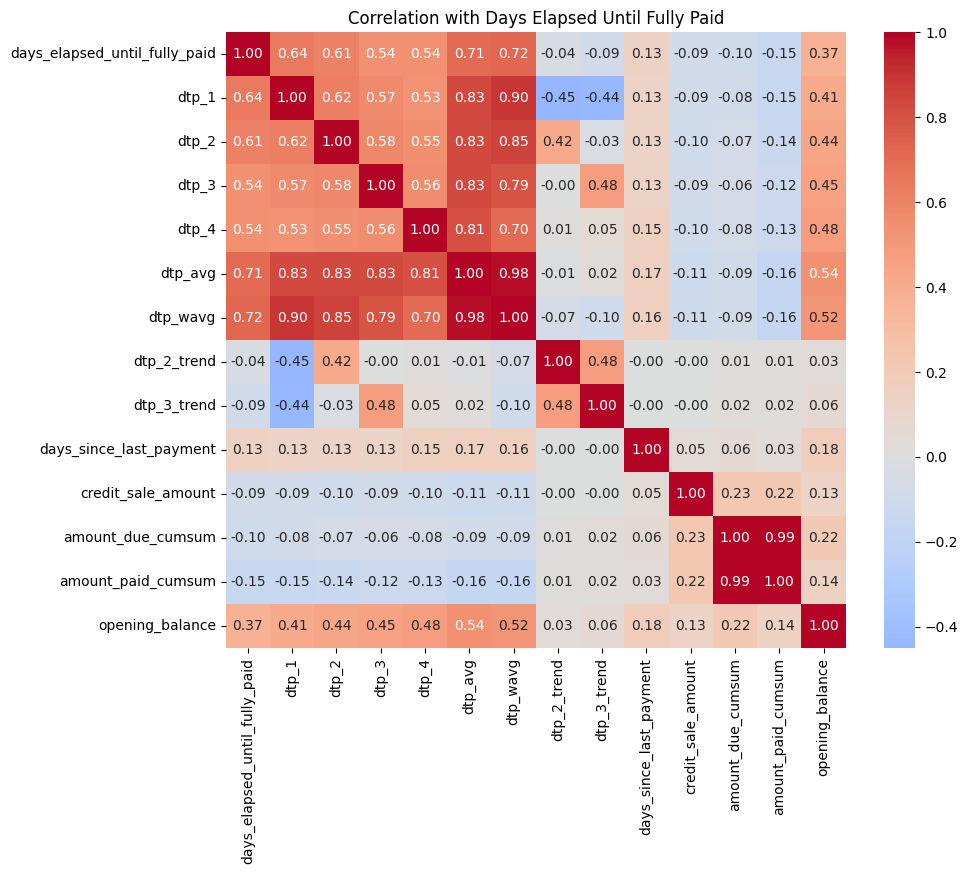

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

df_credit_sales = df_credit_sales.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'])

# Select relevant columns
cols = ['days_elapsed_until_fully_paid', 
        'dtp_1', 'dtp_2', 'dtp_3', 'dtp_4', 
        'dtp_avg', 'dtp_wavg', 'dtp_2_trend',
        'dtp_3_trend', 'days_since_last_payment',
        'credit_sale_amount', 'amount_due_cumsum',
        'amount_paid_cumsum', 'opening_balance']

# Compute correlation matrix
corr = df_credit_sales[cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation with Days Elapsed Until Fully Paid")
plt.show()

In [25]:
df_credit_sales.columns

Index(['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments',
       'credit_sale_amount', 'due_date', 'date_fully_paid',
       'last_payment_date', 'days_elapsed_until_fully_paid', 'dtp_1', 'dtp_2',
       'dtp_3', 'dtp_4', 'dtp_avg', 'dtp_wavg', 'dtp_2_trend', 'dtp_3_trend',
       'days_since_last_payment', 'amount_due_cumsum', 'amount_paid_cumsum',
       'opening_balance', 'plan_type'],
      dtype='object')

In [24]:
from MachineLearning import ada_boost